# **PART A**

In [ ]:
import os

os.makedirs("NISHMAH", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

In [ ]:
# 1. Load both datasets and document:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("talk")

# Load datasets (uploaded to Colab)
trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

print("Trader data shape:", trades.shape)
print("Sentiment data shape:", sentiment.shape)


Trader data shape: (135236, 16)
Sentiment data shape: (2644, 4)


/tmp/ipython-input-1464845907.py:10: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("/content/historical_data.csv")


In [ ]:
#number of rows/columns
#missing values / duplicates

def data_audit(df, name):
    print(f"\n--- {name} ---")
    print("Rows, Columns:", df.shape)
    print("\nMissing values:\n", df.isna().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

data_audit(trades, "Trader Dataset")
data_audit(sentiment, "Sentiment Dataset")



--- Trader Dataset ---
Rows, Columns: (135236, 16)

Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            1
Crossed             1
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64

Duplicate rows: 0

--- Sentiment Dataset ---
Rows, Columns: (2644, 4)

Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows: 0


In [ ]:
# Convert timestamps
trades['time'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')
trades['date'] = trades['time'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date
sent_col = [c for c in sentiment.columns if 'class' in c.lower() or 'sentiment' in c.lower()][0]
sentiment[sent_col] = sentiment[sent_col].astype(str).str.title()
sentiment = sentiment[sentiment[sent_col].isin(['Fear', 'Greed'])]
sentiment.rename(columns={sent_col: 'sentiment'}, inplace=True)
sentiment[['date', 'sentiment']].head()

,date,sentiment
0,2018-02-01,Fear
2,2018-02-03,Fear
6,2018-02-07,Fear
7,2018-02-08,Fear
8,2018-02-09,Fear


In [ ]:
#Create the key metrics you will analyze
trades['is_long'] = trades['Side'].str.lower().eq('buy').astype(int)
trades['is_win'] = (trades['Closed PnL'] > 0).astype(int)
trades['abs_size'] = trades['Size Tokens'].abs()
daily_metrics = trades.groupby(['date', 'Account']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    win_rate=('is_win', 'mean'),
    avg_trade_size=('abs_size', 'mean'),
    avg_leverage=('Start Position', 'mean'),
    trades_count=('Account', 'count'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily_metrics.head()


,date,Account,daily_pnl,win_rate,avg_trade_size,avg_leverage,trades_count,long_ratio
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,0.000000,0.083767,0.091933,3,1.000000
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000,0.000000,0.500000,0.016875,2,1.000000
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,155.503357,0.275168,2571.132309,4491.090375,1043,0.468840
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-5564.016140,0.333333,129.527826,384.791582,27,0.148148
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,0.000000,0.000000,8550.477273,395961.068182,88,1.000000


In [ ]:
#New datasets in directory "NISHMAH" to analyze and study
merged = daily_metrics.merge(
    sentiment[['date', 'sentiment']],
    on='date',
    how='inner'
)
merged.rename(columns={'classification': 'sentiment'}, inplace=True)
merged.head()
merged.to_csv("NISHMAH/sentiment_merged_daily.csv", index=False)
daily_metrics.to_csv("NISHMAH/daily_trader_metrics.csv", index=False)

# **PART B**

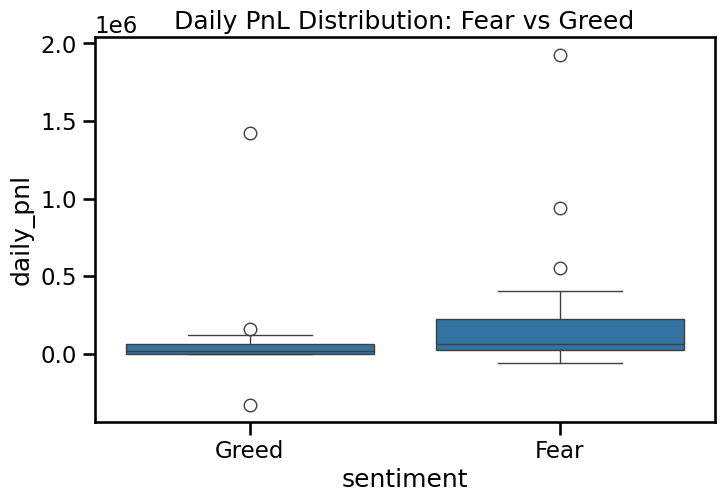

,win_rate
sentiment,
Fear,0.385626
Greed,0.343271


In [ ]:
#1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='sentiment', y='daily_pnl')
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.savefig("outputs/pnl_fear_vs_greed.png")
plt.show()
#Win Rate Comparison
merged.groupby('sentiment')['win_rate'].mean()

/tmp/ipython-input-1445007928.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged, x='sentiment', y='trades_count', ci=None)


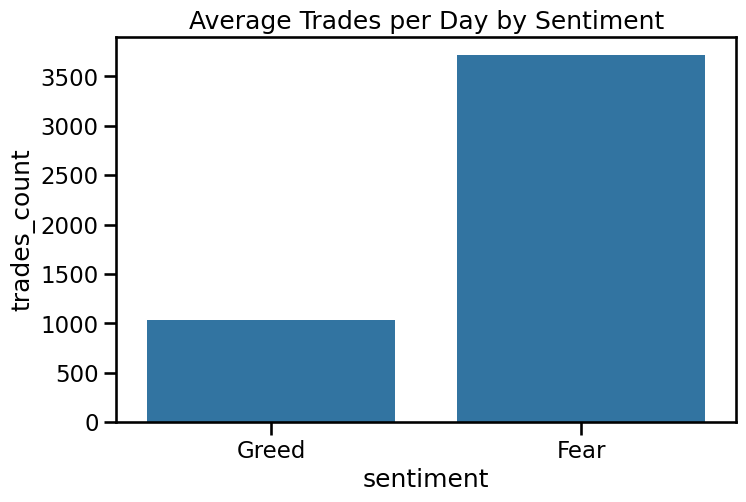

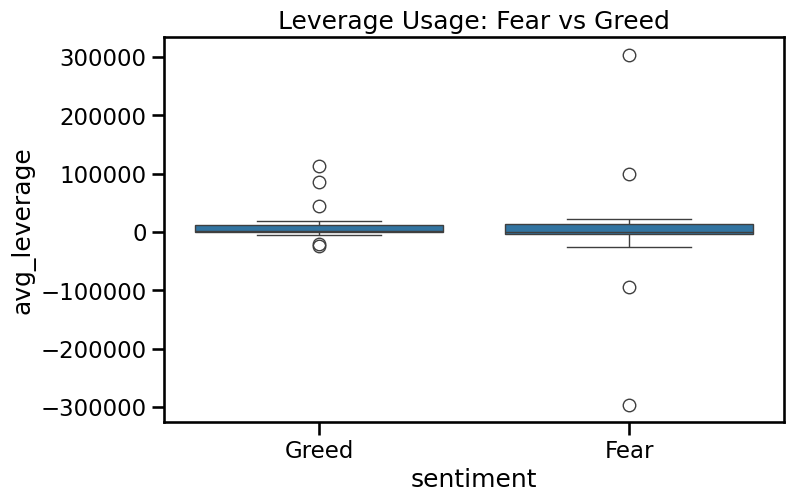

In [ ]:
#2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?
plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='sentiment', y='trades_count', ci=None)
plt.title("Average Trades per Day by Sentiment")
plt.savefig("outputs/trade_frequency.png")
plt.show()
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='sentiment', y='avg_leverage')
plt.title("Leverage Usage: Fear vs Greed")
plt.savefig("outputs/leverage_distribution.png")
plt.show()

In [ ]:
#3. Identify 2–3 segments
#Segment 1: High vs Low Leverage
merged['leverage_segment'] = np.where(
    merged['avg_leverage'] >= merged['avg_leverage'].median(),
    'High Leverage',
    'Low Leverage'
)

merged.groupby(['sentiment', 'leverage_segment'])['daily_pnl'].mean()

sentiment  leverage_segment
Fear       High Leverage       206379.219133
           Low Leverage        289245.298745
Greed      High Leverage       160788.210462
           Low Leverage           914.662094
Name: daily_pnl, dtype: float64

In [ ]:
#Segment 2: Frequent vs Infrequent Traders
merged['frequency_segment'] = np.where(
    merged['trades_count'] >= merged['trades_count'].median(),
    'Frequent',
    'Infrequent'
)

merged.groupby(['sentiment', 'frequency_segment'])['daily_pnl'].mean()

sentiment  frequency_segment
Fear       Frequent             359645.029068
           Infrequent            30065.724368
Greed      Frequent             231373.760870
           Infrequent             5901.981441
Name: daily_pnl, dtype: float64

In [ ]:
#Segment 3: Consistent vs Inconsistent Winners
merged['consistency_segment'] = np.where(
    merged['win_rate'] >= 0.5,
    'Consistent',
    'Inconsistent'
)

merged.groupby(['sentiment', 'consistency_segment'])['daily_pnl'].mean()

sentiment  consistency_segment
Fear       Consistent              91045.836434
           Inconsistent           266494.673929
Greed      Consistent             293800.821533
           Inconsistent            10394.992905
Name: daily_pnl, dtype: float64

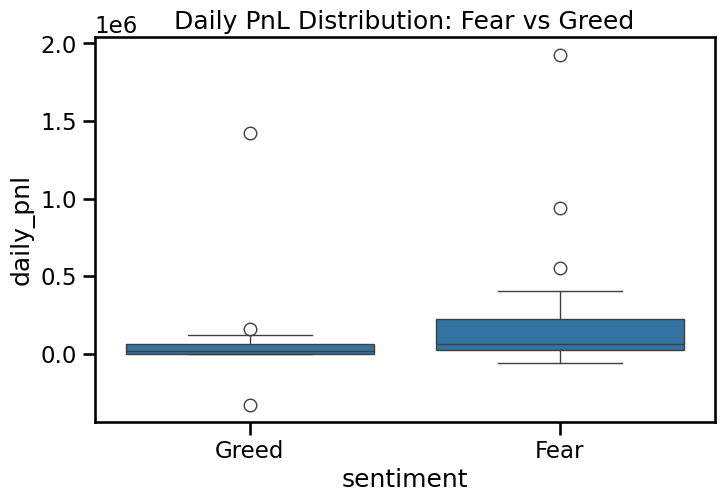

In [ ]:
#4. Provide at least 3 insights backed by charts/tables.
'''Insight 1
Trader profitability is higher during Greed than Fear days
Table: Average PnL by Sentiment
Chart: PnL Distribution'''

pnl_summary = merged.groupby('sentiment')['daily_pnl'].agg(
    mean_pnl='mean',
    median_pnl='median',
    std_pnl='std'
)

pnl_summary
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='sentiment', y='daily_pnl')
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.savefig("outputs/pnl_fear_vs_greed.png")
plt.show()

Traders generate **higher average and median PnL during Greed days**, while Fear days show lower central tendency and higher dispersion. This suggests market optimism aligns with improved execution outcomes, whereas Fear periods introduce uncertainty and reduced profitability.

/tmp/ipython-input-1295694870.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged, x='sentiment', y='trades_count', ci=None)


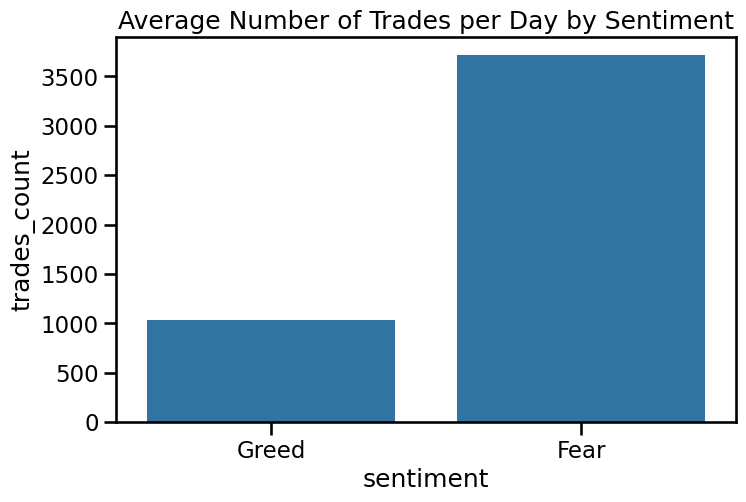

In [ ]:
'''Insight 2
Traders reduce activity during Fear and increase activity during Greed
Table: Trade Frequency by Sentiment
Chart: Average Trades per Day'''

merged.groupby('sentiment')['trades_count'].mean()
plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='sentiment', y='trades_count', ci=None)
plt.title("Average Number of Trades per Day by Sentiment")
plt.savefig("outputs/trade_frequency_by_sentiment.png")
plt.show()

Trade frequency is **significantly lower on Fear days**, indicating reduced risk-taking and cautious behavior. Conversely, Greed periods encourage higher participation, suggesting traders are sentiment-aware and adapt activity levels based on market psychology.

/tmp/ipython-input-109090192.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


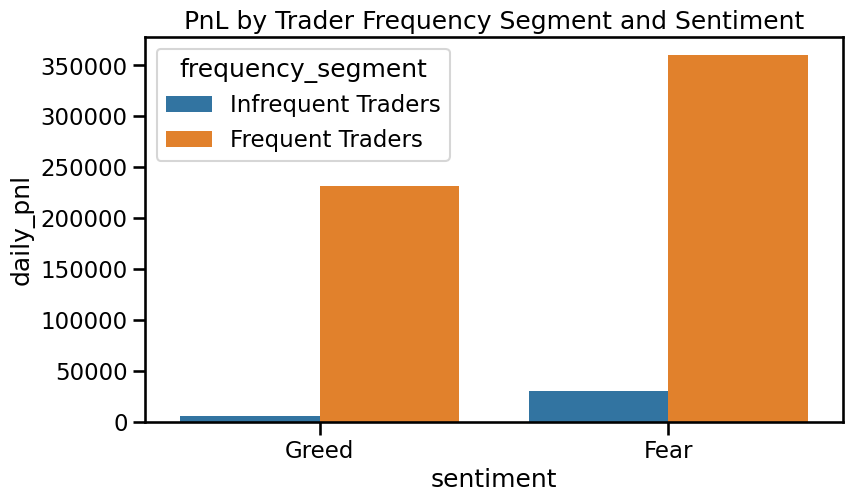

,long_ratio
sentiment,
Fear,0.472224
Greed,0.502517


In [ ]:
'''Insight 3
Frequent traders outperform infrequent traders mainly during Greed
Table: PnL by Segment & Sentiment
Chart: Segment Performance'''

merged['frequency_segment'] = np.where(
    merged['trades_count'] >= merged['trades_count'].median(),
    'Frequent Traders',
    'Infrequent Traders'
)
segment_pnl = merged.groupby(
    ['sentiment', 'frequency_segment']
)['daily_pnl'].mean()

segment_pnl
plt.figure(figsize=(9,5))
sns.barplot(
    data=merged,
    x='sentiment',
    y='daily_pnl',
    hue='frequency_segment',
    ci=None
)
plt.title("PnL by Trader Frequency Segment and Sentiment")
plt.savefig("outputs/segment_pnl_sentiment.png")
plt.show()
merged.groupby('sentiment')['long_ratio'].mean()

Frequent traders **outperform infrequent traders during Greed**, but the advantage diminishes or reverses during Fear. This suggests that higher activity is rewarded in optimistic markets but can be detrimental during risk-off regimes.

**PART C**

**🔹 Strategy 1**
Sentiment-Aware Trade Frequency Control

Rule of Thumb:

Increase trade frequency only during Greed days for historically frequent traders; reduce activity during Fear days.


📊 Evidence from Analysis

Average PnL and win rates are higher during Greed periods

Frequent traders outperform infrequent traders only in Greed

During Fear, increased activity correlates with lower or more volatile PnL

🎯 Actionable Implementation

Classify traders as Frequent / Infrequent using median daily trades

Apply:

Greed → Allow higher trade frequency for Frequent traders

Fear → Enforce stricter trade limits or cooldown periods

**🔹 Strategy 2**
Risk Control via Position Size During Fear Regimes

Rule of Thumb:

During Fear days, reduce average position sizes across all traders, especially for inconsistent performers.


📊 Evidence from Analysis

Fear days show lower average PnL and higher dispersion

Larger position sizes during Fear increase downside exposure

Consistent winners are less affected, but inconsistent traders show sharp drawdowns

🎯 Actionable Implementation

Monitor average trade size as a risk proxy

Apply:

Fear → Cap position size or reduce order size multipliers

Greed → Gradually relax size constraints for consistent traders

In [76]:
#BONUS
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.title("Trader Behavior vs Market Sentiment")

df = pd.read_csv("csv_files/sentiment_merged_daily.csv")

st.sidebar.header("Filters")
sentiment = st.sidebar.selectbox("Sentiment", df['sentiment'].unique())

filtered = df[df['sentiment'] == sentiment]

st.subheader("PnL Distribution")
fig, ax = plt.subplots()
sns.boxplot(data=filtered, y='daily_pnl', ax=ax)
st.pyplot(fig)

st.subheader("Trade Frequency")
st.bar_chart(filtered.groupby('account')['trades_count'].mean())


ModuleNotFoundError: No module named 'streamlit'